In [1]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset


class AirfoilDataset(Dataset):
    '''
    airfoil dataset: no need to modify
    '''
    def __init__(self, path='./airfoils'):
        super(AirfoilDataset, self).__init__()
        self._X = []    # x coordinates of all airfoils (shared)
        self._Y = []    # y coordinates of all airfoils
        self.names = [] # name of all airfoils
        self.norm_coeff = 0	# normalization coeff to scale y to [-1, 1]
        airfoil_fn = [afn for afn in os.listdir(path) if afn.endswith('.dat')]

        # get x coordinates of all airfoils
        with open(os.path.join(path, airfoil_fn[0]), 'r', encoding="utf8", errors='ignore') as f:
            raw_data = f.readlines()
            for idx in range(len(raw_data)):
                raw_xy = raw_data[idx].split(' ')
                while "" in raw_xy:
                    raw_xy.remove("")
                self._X.append(float(raw_xy[0]))
        self._X = np.array(self._X)

        # get y coordinates of each airfoils
        for idx, fn in enumerate(airfoil_fn):
            with open(os.path.join(path, fn), 'r', encoding="utf8", errors='ignore') as f:
                self.names.append(fn[:-10])
                raw_data = f.readlines()
                airfoil = np.empty(self._X.shape[0])
                for i in range(len(raw_data)):
                    raw_xy = raw_data[i].split(' ')
                    while "" in raw_xy:
                        raw_xy.remove("")
                    curr_y = float(raw_xy[1])
                    airfoil[i] = curr_y
                    self.norm_coeff = max(self.norm_coeff, np.abs(curr_y))
                self._Y.append(airfoil)

        self._Y = np.array([airfoil / self.norm_coeff for airfoil in self._Y], dtype=np.float32)

    def get_x(self):
        '''
        get shared x coordinates
        '''
        return self._X

    def get_y(self):
        '''
        get y coordinates of all airfoils
        '''
        return self._Y

    def __getitem__(self, idx):
        return self._Y[idx], self.names[idx]
        
    def __len__(self):
        return len(self._Y)


In [2]:
import torch
import torch.nn as nn


class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        # build your model here
        # your output should be of dim (batch_size, 1)
        # since discriminator is a binary classifier
        self.Discriminator = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    
    def forward(self, x):
        # define your feedforward pass
        foil = self.Discriminator(x)
        return foil


class Generator(nn.Module):
    def __init__(self, latent_dim, airfoil_dim):
        super(Generator, self).__init__()
        # build your model here
        # your output should be of dim (batch_size, airfoil_dim)
        # you can use tanh() as the activation for the last layer
        # since y coord of airfoils range from -1 to 1
        self.Generator = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, airfoil_dim),
            nn.Tanh()
        )

    def forward(self, x):
        foil = self.Generator(x)
        return foil

In [3]:
dis = Discriminator(input_dim=200)
gen = Generator(latent_dim=20, airfoil_dim=200)
print(dis)
print(gen)

Discriminator(
  (Discriminator): Sequential(
    (0): Linear(in_features=200, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=256, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
Generator(
  (Generator): Sequential(
    (0): Linear(in_features=20, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=200, bias=True)
    (7): Tanh()
  )
)


In [4]:
'''
Utility functions 
Free from to add functions if needed
'''

import torch
import matplotlib.pyplot as plt


def plot_airfoils(airfoil_x, airfoil_y):
    '''
    plot airfoils: no need to modify 
    '''
    idx = 0
    fig, ax = plt.subplots(nrows=4, ncols=4)
    for row in ax:
        for col in row:
            col.scatter(airfoil_x, airfoil_y[idx, :], s=0.6, c='black')
            col.axis('off')
            col.axis('equal')
            idx += 1
    plt.show()

Distrminator model:
 Discriminator(
  (Discriminator): Sequential(
    (0): Linear(in_features=200, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=256, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
Generator model:
 Generator(
  (Generator): Sequential(
    (0): Linear(in_features=16, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=200, bias=True)
    (7): Tanh()
  )
)
Epoch: [0/200], Batch: 29, Discriminator loss: 0.678256630897522, Generator loss: 0.8806952238082886
Epoch: [0/200], Batch: 59, Discriminator loss: 0.684645414352417, Gen

Epoch: [23/200], Batch: 89, Discriminator loss: 0.6989209651947021, Generator loss: 0.6837399005889893
Epoch: [24/200], Batch: 29, Discriminator loss: 0.6867782473564148, Generator loss: 0.709461510181427
Epoch: [24/200], Batch: 59, Discriminator loss: 0.693949282169342, Generator loss: 0.677216112613678
Epoch: [24/200], Batch: 89, Discriminator loss: 0.6951442956924438, Generator loss: 0.711103081703186
Epoch: [25/200], Batch: 29, Discriminator loss: 0.692836582660675, Generator loss: 0.6950049996376038
Epoch: [25/200], Batch: 59, Discriminator loss: 0.6892222762107849, Generator loss: 0.6889173984527588
Epoch: [25/200], Batch: 89, Discriminator loss: 0.7565250992774963, Generator loss: 0.5933141708374023
Epoch: [26/200], Batch: 29, Discriminator loss: 0.6937897205352783, Generator loss: 0.705389142036438
Epoch: [26/200], Batch: 59, Discriminator loss: 0.7033146023750305, Generator loss: 0.6609103083610535
Epoch: [26/200], Batch: 89, Discriminator loss: 0.6893943548202515, Generator l

Epoch: [50/200], Batch: 29, Discriminator loss: 0.6894214153289795, Generator loss: 0.7049660682678223
Epoch: [50/200], Batch: 59, Discriminator loss: 0.6895833611488342, Generator loss: 0.7284941673278809
Epoch: [50/200], Batch: 89, Discriminator loss: 0.6947381496429443, Generator loss: 0.6893672943115234
Epoch: [51/200], Batch: 29, Discriminator loss: 0.6928911209106445, Generator loss: 0.744413435459137
Epoch: [51/200], Batch: 59, Discriminator loss: 0.6910261511802673, Generator loss: 0.6991360187530518
Epoch: [51/200], Batch: 89, Discriminator loss: 0.6915515065193176, Generator loss: 0.6894159913063049
Epoch: [52/200], Batch: 29, Discriminator loss: 0.6953915357589722, Generator loss: 0.6254881620407104
Epoch: [52/200], Batch: 59, Discriminator loss: 0.6930288076400757, Generator loss: 0.6713458299636841
Epoch: [52/200], Batch: 89, Discriminator loss: 0.6926237344741821, Generator loss: 0.6889263391494751
Epoch: [53/200], Batch: 29, Discriminator loss: 0.6902390718460083, Genera

Epoch: [76/200], Batch: 59, Discriminator loss: 0.7073057889938354, Generator loss: 0.7975863218307495
Epoch: [76/200], Batch: 89, Discriminator loss: 0.6930000185966492, Generator loss: 0.6897712349891663
Epoch: [77/200], Batch: 29, Discriminator loss: 0.6902086734771729, Generator loss: 0.7049612402915955
Epoch: [77/200], Batch: 59, Discriminator loss: 0.6625442504882812, Generator loss: 0.6610639095306396
Epoch: [77/200], Batch: 89, Discriminator loss: 0.6873253583908081, Generator loss: 0.6781540513038635
Epoch: [78/200], Batch: 29, Discriminator loss: 0.7027275562286377, Generator loss: 0.7622084617614746
Epoch: [78/200], Batch: 59, Discriminator loss: 0.6927762031555176, Generator loss: 0.6823703050613403
Epoch: [78/200], Batch: 89, Discriminator loss: 0.694085955619812, Generator loss: 0.736444354057312
Epoch: [79/200], Batch: 29, Discriminator loss: 0.6910211443901062, Generator loss: 0.7056795358657837
Epoch: [79/200], Batch: 59, Discriminator loss: 0.6891957521438599, Generat

Epoch: [102/200], Batch: 89, Discriminator loss: 0.6898358464241028, Generator loss: 0.7908338904380798
Epoch: [103/200], Batch: 29, Discriminator loss: 0.6842859983444214, Generator loss: 0.6815932393074036
Epoch: [103/200], Batch: 59, Discriminator loss: 0.6854018568992615, Generator loss: 0.7483932971954346
Epoch: [103/200], Batch: 89, Discriminator loss: 0.6781660914421082, Generator loss: 0.7099917531013489
Epoch: [104/200], Batch: 29, Discriminator loss: 0.7024356126785278, Generator loss: 0.6978514194488525
Epoch: [104/200], Batch: 59, Discriminator loss: 0.6925504803657532, Generator loss: 0.738875150680542
Epoch: [104/200], Batch: 89, Discriminator loss: 0.6957381963729858, Generator loss: 0.7784092426300049
Epoch: [105/200], Batch: 29, Discriminator loss: 0.7143343687057495, Generator loss: 0.6690592765808105
Epoch: [105/200], Batch: 59, Discriminator loss: 0.7004361152648926, Generator loss: 0.6875396370887756
Epoch: [105/200], Batch: 89, Discriminator loss: 0.68681484460830

Epoch: [128/200], Batch: 89, Discriminator loss: 0.6875128149986267, Generator loss: 0.6570866107940674
Epoch: [129/200], Batch: 29, Discriminator loss: 0.6950758695602417, Generator loss: 0.6900593042373657
Epoch: [129/200], Batch: 59, Discriminator loss: 0.7135376930236816, Generator loss: 0.6473790407180786
Epoch: [129/200], Batch: 89, Discriminator loss: 0.7106525301933289, Generator loss: 0.6694252490997314
Epoch: [130/200], Batch: 29, Discriminator loss: 0.6879503130912781, Generator loss: 0.6857303977012634
Epoch: [130/200], Batch: 59, Discriminator loss: 0.6994649171829224, Generator loss: 0.6817246675491333
Epoch: [130/200], Batch: 89, Discriminator loss: 0.6923009753227234, Generator loss: 0.6920852065086365
Epoch: [131/200], Batch: 29, Discriminator loss: 0.6804088950157166, Generator loss: 0.8522633910179138
Epoch: [131/200], Batch: 59, Discriminator loss: 0.686031699180603, Generator loss: 0.7051724195480347
Epoch: [131/200], Batch: 89, Discriminator loss: 0.69506466388702

Epoch: [154/200], Batch: 89, Discriminator loss: 0.6901882290840149, Generator loss: 0.7227988243103027
Epoch: [155/200], Batch: 29, Discriminator loss: 0.6872827410697937, Generator loss: 0.6416897773742676
Epoch: [155/200], Batch: 59, Discriminator loss: 0.6983262300491333, Generator loss: 0.6684478521347046
Epoch: [155/200], Batch: 89, Discriminator loss: 0.6943413019180298, Generator loss: 0.6520370841026306
Epoch: [156/200], Batch: 29, Discriminator loss: 0.7297645211219788, Generator loss: 0.6454012393951416
Epoch: [156/200], Batch: 59, Discriminator loss: 0.7014036178588867, Generator loss: 0.6911764144897461
Epoch: [156/200], Batch: 89, Discriminator loss: 0.6796226501464844, Generator loss: 0.6937381029129028
Epoch: [157/200], Batch: 29, Discriminator loss: 0.6854836344718933, Generator loss: 0.692249059677124
Epoch: [157/200], Batch: 59, Discriminator loss: 0.6948782205581665, Generator loss: 0.6866337656974792
Epoch: [157/200], Batch: 89, Discriminator loss: 0.69470560550689

Epoch: [180/200], Batch: 89, Discriminator loss: 0.6766225099563599, Generator loss: 0.7453994154930115
Epoch: [181/200], Batch: 29, Discriminator loss: 0.6639509201049805, Generator loss: 1.0208442211151123
Epoch: [181/200], Batch: 59, Discriminator loss: 0.6827775239944458, Generator loss: 0.6780500411987305
Epoch: [181/200], Batch: 89, Discriminator loss: 0.7066287398338318, Generator loss: 0.6692141890525818
Epoch: [182/200], Batch: 29, Discriminator loss: 0.6998308300971985, Generator loss: 0.7134473919868469
Epoch: [182/200], Batch: 59, Discriminator loss: 0.6924208402633667, Generator loss: 0.7689681053161621
Epoch: [182/200], Batch: 89, Discriminator loss: 0.6947664618492126, Generator loss: 0.7175596356391907
Epoch: [183/200], Batch: 29, Discriminator loss: 0.68523770570755, Generator loss: 0.6790178418159485
Epoch: [183/200], Batch: 59, Discriminator loss: 0.719928503036499, Generator loss: 0.7998639345169067
Epoch: [183/200], Batch: 89, Discriminator loss: 0.6974765062332153

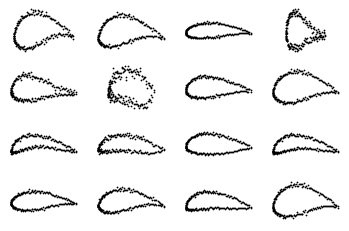

In [5]:
'''
train and test GAN model on airfoils
'''

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
import numpy as np
from torch.autograd import Variable
import torch.nn.functional as F

#from dataset import AirfoilDataset
#from gan import Discriminator, Generator
#from utils import *


def main():
    # check if cuda available
    cuda = True if torch.cuda.is_available() else False
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
    
    # define dataset and dataloader
    dataset = AirfoilDataset()
    airfoil_x = dataset.get_x()
    airfoil_dim = airfoil_x.shape[0]
    airfoil_dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    # hyperparameters
    latent_dim = 16 # please do not change latent dimension
    lr_dis = 0.0005 # discriminator learning rate
    lr_gen = 0.0005 # generator learning rate
    BETA1 = 0.5
    BETA2 = 0.999
    num_epochs = 200
    
    # build the model
    dis = Discriminator(input_dim=airfoil_dim).to(device)
    gen = Generator(latent_dim=latent_dim, airfoil_dim=airfoil_dim).to(device)
    print("Distrminator model:\n", dis)
    print("Generator model:\n", gen)

    # define your GAN loss function here
    # you may need to define your own GAN loss function/class
    # loss = ?
    def dis_loss(inputs, hits):
        return nn.BCELoss()(inputs, hits)
    
    def gen_loss(inputs):
        hits = torch.ones([inputs.shape[0], 1])
        hits = hits.to(device)
        return nn.BCELoss()(inputs, hits)
    
    # define optimizer for discriminator and generator separately
    optim_dis = Adam(dis.parameters(), lr=lr_dis, betas = (BETA1,BETA2))
    optim_gen = Adam(gen.parameters(), lr=lr_gen, betas = (BETA1,BETA2))
    
    # train the GAN model
    for epoch in range(num_epochs):
        for n_batch, (local_batch, __) in enumerate(airfoil_dataloader):
            y_real = local_batch.to(device)
            
            real_data = y_real.view(-1, 200)
            real_out = dis(real_data)
            real_L = torch.ones(real_data.shape[0], 1).to(device)
            
            
            z = Variable(Tensor(np.random.normal(0, 1, (y_real.shape[0], latent_dim))))
            fakes = gen(z)
            fakes_out = dis(fakes)
            fake_L = torch.zeros(fakes.shape[0], 1).to(device)
            
            out = torch.cat((real_out, fakes_out), 0)
            hits = torch.cat((real_L, fake_L), 0)
            
            optim_dis.zero_grad()
            
            d_loss = dis_loss(out, hits)
            d_loss.backward()
            optim_dis.step()
            
            z = Variable(Tensor(np.random.normal(0, 1, (y_real.shape[0], latent_dim))))
            fakes = gen(z)
            fakes_out = dis(fakes)

            g_loss = gen_loss(fakes_out)
            optim_gen.zero_grad()
            g_loss.backward()
            optim_gen.step()
            
            # print loss while training
            if (n_batch + 1) % 30 == 0:
                print("Epoch: [{}/{}], Batch: {}, Discriminator loss: {}, Generator loss: {}".format(
                    epoch, num_epochs, n_batch, d_loss.item(), g_loss.item()))

    # test trained GAN model
    num_samples = 100
    # create random noise 
    noise = torch.randn((num_samples, latent_dim)).to(device)
    # generate airfoils
    gen_airfoils = gen(noise)
    if 'cuda' in device:
        gen_airfoils = gen_airfoils.detach().cpu().numpy()
    else:
        gen_airfoils = gen_airfoils.detach().numpy()

    # plot generated airfoils
    plot_airfoils(airfoil_x, gen_airfoils)
    
    torch.save(gen,'p1_gen_model_V3.pth')
    torch.save(dis,'p1_dis_model_V3.pth')

if __name__ == "__main__":
    main()


In [20]:
import torch
import torch.nn as nn


###########################################
class VAE(nn.Module):
    def __init__(self, airfoil_dim, latent_dim):
        super().__init__()
        input_dim = airfoil_dim 
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512,256)
        self.fc31 = nn.Linear(256,latent_dim)
        self.fc32 = nn.Linear(256, latent_dim)
        self.fc4 = nn.Linear(latent_dim, 256)
        self.fc5 = nn.Linear(256,512)
        self.fc6 = nn.Linear(512, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        return self.fc31(h2), self.fc32(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc4(z))
        h4 = F.relu(self.fc5(h3))
        return torch.sigmoid(self.fc6(h4))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 200))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    


VAE model:
 VAE(
  (fc1): Linear(in_features=200, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=16, bias=True)
  (fc32): Linear(in_features=256, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=200, bias=True)
)
Epoch: [0/35], Batch: 29, loss: -2032.644775390625
Epoch: [0/35], Batch: 59, loss: -4223.9169921875
Epoch: [0/35], Batch: 89, loss: -3666.10888671875
Epoch: [1/35], Batch: 29, loss: -2874.1025390625
Epoch: [1/35], Batch: 59, loss: -2783.8935546875
Epoch: [1/35], Batch: 89, loss: -2684.806884765625
Epoch: [2/35], Batch: 29, loss: -3524.30859375
Epoch: [2/35], Batch: 59, loss: -5435.6396484375
Epoch: [2/35], Batch: 89, loss: -6636.9052734375
Epoch: [3/35], Batch: 29, loss: -6623.94384765625
Epoch: [3/35], Batch: 59, loss: -10012.7587890625
Epoc

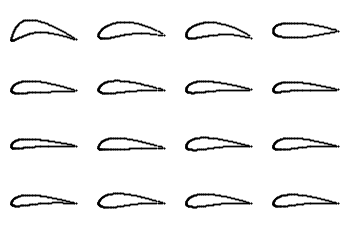

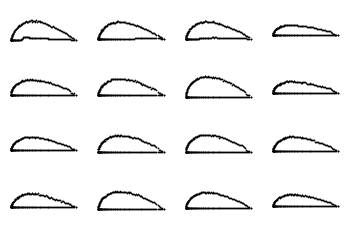

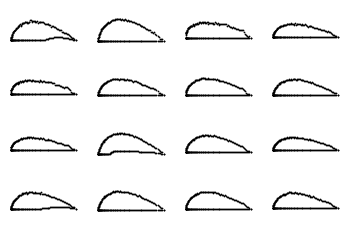

In [23]:
'''
train and test VAE model on airfoils
'''

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import functional as F
import numpy as np

#from dataset import AirfoilDataset
#from vae import VAE
#from utils import *


def main():
    # check if cuda available
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

    # define dataset and dataloader
    dataset = AirfoilDataset()
    airfoil_x = dataset.get_x()
    airfoil_dim = airfoil_x.shape[0]
    airfoil_dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    # hyperparameters
    latent_dim = 16 # please do not change latent dimension
    lr = 0.001      # learning rate
    num_epochs = 35

    # build the model
    vae = VAE(airfoil_dim=airfoil_dim, latent_dim=latent_dim).to(device)
    print("VAE model:\n", vae)

    # define your loss function here
    # loss = ?
    def loss_function(recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x.view(-1, airfoil_dim), reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD
    # define optimizer for discriminator and generator separately
    optim = Adam(vae.parameters(), lr=lr)
    
    # train the VAE model
    for epoch in range(num_epochs):
        vae.train() #
        train_loss = 0 #
        for n_batch, (local_batch, __) in enumerate(airfoil_dataloader):
            y_real = local_batch.to(device)
            optim.zero_grad()
            # train VAE
            # calculate customized VAE loss
            # loss = your_loss_func(...)
            recon_batch, mu, logvar = vae(y_real)
            loss = loss_function(recon_batch, y_real,mu,logvar)
            loss.backward()
            train_loss += loss.item() 
            optim.step()

            # print loss while training
            if (n_batch + 1) % 30 == 0:
                print("Epoch: [{}/{}], Batch: {}, loss: {}".format(
                    epoch, num_epochs, n_batch, loss.item()))

    # test trained VAE model
    num_samples = 100

    # reconstuct airfoils
    real_airfoils = dataset.get_y()[:num_samples]
    recon_airfoils, __, __ = vae(torch.from_numpy(real_airfoils).to(device))
    if 'cuda' in device:
        recon_airfoils = recon_airfoils.detach().cpu().numpy()
    else:
        recon_airfoils = recon_airfoils.detach().numpy()
    
    # randomly synthesize airfoils
    noise = torch.randn((num_samples, latent_dim)).to(device)   # create random noise 
    gen_airfoils = vae.decode(noise)
    if 'cuda' in device:
        gen_airfoils = gen_airfoils.detach().cpu().numpy()
    else:
        gen_airfoils = gen_airfoils.detach().numpy()

    # plot real/reconstructed/synthesized airfoils
    plot_airfoils(airfoil_x, real_airfoils)
    plot_airfoils(airfoil_x, recon_airfoils)
    plot_airfoils(airfoil_x, gen_airfoils)
    
    torch.save(vae,'p1_vae_model_V4.pth')
if __name__ == "__main__":
    main()